In [1]:
from datetime import date, timedelta, datetime

import pandas as pd
import numpy as np
import time
import lightgbm as lgb
#from com_util import *
import gc
import os
import xgboost as xgb
import lightgbm as lgb
from scipy import stats 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config ZMQInteractiveShell.ast_node_interactivity='all'
%pprint

# 大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 风格设置
sns.set_style("whitegrid")


plot = True

goal = 'price'
myid = 'SaleID'


Pretty printing has been turned OFF


### 简单看看：https://zhuanlan.zhihu.com/p/38622109

后期可以考虑：

- 车龄前五年折旧率：16%、12%、10%、8%、6%，逐年价格
- 车分淡季旺季

In [ ]:
# 画图大小设置
sns.set(rc={'figure.figsize':(13,7)})
# 画图风格设置
sns.set_style("whitegrid")

# 处理函数

- topK相关系数图

In [2]:
def corr_plot(dt, topk=30):
    tmp = dt[dt.isTrain==1]
    cols = np.abs(tmp.corr()).nlargest(topk, 'price')['price'].index
    cn = np.corrcoef(tmp[cols].values.T)
    sns.heatmap(cn, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size':10},
                yticklabels=cols.values, 
                xticklabels=cols.values)

# 正式数据处理

- 将训练集与测试集统一在一起处理，为了保证数据处理的一致性，用isTrain来标识训练集与测试集

In [3]:
df_train = pd.read_csv('../data/used_car_train_20200313.csv',sep=' ', parse_dates=['regDate', 'creatDate'])
df_test = pd.read_csv('../data/used_car_testA_20200313.csv', sep=' ', parse_dates=['regDate', 'creatDate'])
df_train["price"] = df_train["price"].apply(lambda x: np.log1p(float(x)) if float(x) > 0 else 0)
df_test["price"] = 0
df_train["isTrain"] = 1
df_test["isTrain"] = 0

dt = pd.concat([df_train, df_test], ignore_index=True)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


## 日期

- regYear缺失很多月份，即很多月份为00，年份有，但是不影响，我们只需要关注注册的年份即可。
- 通过creatYear发现二手车交易数据年份为2015、2016，为此查找相关资料找到15、16年的节假日信息。
- 构造了是否节假日、星期、车龄等特征，为了保证周期的连续性，对星期进行了sin/cos处理。
- 并构建了2015、2016两年的销量和价格的同比、差分、环比等指标特征。
- 增加是否周末等指标。
- 新的特征 "days_to_side" 表示当天距离月初月末的最短距离。
- day的月初、月中、月末指标（把月初月末的定义改成了7天）。

In [4]:
dt["regYear"] = dt.regDate.apply(lambda x:x[:4]).astype(int)
dt["creatYear"] = dt.creatDate.apply(lambda x: x.year)
# 车售出距离当前天数
cur_date = np.max(dt.creatDate)
dt["salesDays"] = dt.creatDate.apply(lambda x: (cur_date-x).days)
# 车龄
dt["car_age"] = dt["creatYear"] - dt["regYear"]

del dt["regDate"]

dt["day_of_week"] = dt.creatDate.apply(lambda x: x.weekday()) + 1
dt["holiday"] = (dt["day_of_week"]>=6).astype(int)
holiday = ['2015-01-01', '2015-01-02', '2015-01-03', '2015-01-18', '2015-01-19', 
           '2015-01-20', '2015-01-21', '2015-01-22', '2015-01-23', '2015-01-24', 
           '2015-04-05', '2015-04-06', '2015-05-01', '2015-06-20', '2015-06-21', 
           '2015-06-22', '2015-09-27', '2015-10-01', '2015-10-02', '2015-10-03', 
           '2015-10-04', '2015-10-05', '2015-10-06', '2015-10-07', 
           '2016-01-01', '2016-01-02', '2016-01-03', '2016-02-07', '2016-02-08', 
           '2016-02-09', '2016-02-10', '2016-02-11', '2016-02-12', '2016-02-13', 
           '2016-04-04', '2016-04-05', '2016-04-06', '2016-05-01', '2016-05-02', 
           '2016-06-09', '2016-06-10', '2016-06-11', '2016-09-15', '2016-09-16', 
           '2016-09-17', '2016-10-01', '2016-10-02', '2016-10-03', '2016-10-04', 
           '2016-10-05', '2016-10-06', '2016-10-07']
no_holiday = ['2015-01-04', '2015-02-15', '2015-02-28', '2015-10-10', '2016-02-06', 
              '2016-02-14', '2016-06-12', '2016-09-18', '2016-10-08', '2016-10-09']

for i in holiday:
    dt.loc[dt.creatDate==i, "creatDate"] = 1
    

for i in no_holiday:
    dt.loc[dt.creatDate==i, "creatDate"] = 0
    
    
    
#生成sin/cos特征

dt['creatWeek_sin'] = np.sin(2 * np.pi * dt.day_of_week/7.0)
dt['creatWeek_cos'] = np.cos(2 * np.pi * dt.day_of_week/7.0)
dt['creatMonth_sin'] = np.sin(2 * np.pi * dt.creatDate.apply(lambda x: x.month)/12.0)
dt['creatMonth_cos'] = np.cos(2 * np.pi * dt.creatDate.apply(lambda x: x.month)/12.0)

dt['creatYearMonth'] = dt.creatDate.apply(lambda x: str(x)[:7])

In [5]:
# 一年的数据构造月级别的差分、同比、环比数据。


####### creatYearMonth_hit
creatYearMonth_hit = dt.creatYearMonth.value_counts().reset_index(inplace=False)
creatYearMonth_hit.columns = ['creatYearMonth', 'creatYearMonth_hit']

# creatYearMonth_hit一阶差分
sort_creatYearMonth_hit = creatYearMonth_hit.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_hit_diff1 = [0] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) - np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_diff1'] = sort_creatYearMonth_hit_diff1
# creatYearMonth_hit上一月环比
sort_creatYearMonth_hit_huanbi = [1] + list(np.array(sort_creatYearMonth_hit.creatYearMonth_hit[1:]) / np.array(sort_creatYearMonth_hit.creatYearMonth_hit[:-1]))
creatYearMonth_hit['creatYearMonth_hit_huanbi'] = sort_creatYearMonth_hit_huanbi
dt = dt.merge(creatYearMonth_hit, how='left', on=['creatYearMonth'])




####### creatYearMonth_price
creatYearMonth_price = dt.loc[:,['creatYearMonth', 'price']].groupby(['creatYearMonth']).mean().reset_index(inplace=False)
creatYearMonth_price.columns = ['creatYearMonth', 'creatYearMonth_price']

# creatYearMonth_price一阶差分
sort_creatYearMonth_price = creatYearMonth_price.sort_values(by='creatYearMonth', ascending=True)
sort_creatYearMonth_price_diff1 = [0] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) - np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_diff1'] = sort_creatYearMonth_price_diff1
# creatYearMonth_price上一月环比
sort_creatYearMonth_price_huanbi = [1] + list(np.array(sort_creatYearMonth_price.creatYearMonth_price[1:]) / np.array(sort_creatYearMonth_price.creatYearMonth_price[:-1]))
creatYearMonth_price['creatYearMonth_price_huanbi'] = sort_creatYearMonth_price_huanbi
dt = dt.merge(creatYearMonth_price, how='left', on=['creatYearMonth'])

del dt['creatYearMonth']


##### 是否周末
dt['creatDate_is_Weekend'] = [1 if day in (0,6) else 0 for day in list(dt.creatDate.apply(lambda x: x.weekday()))]


In [6]:
# 一年的数据构造天级别的差分、同比、环比数据。

dt['creatDateStr'] = dt.creatDate.apply(lambda x: str(x)[:10])

####### creatDateStr_hit
creatDateStr_hit = dt.creatDateStr.value_counts().reset_index(inplace=False)
creatDateStr_hit.columns = ['creatDateStr', 'creatDateStr_hit']

# creatDateStr_hit一阶差分
sort_creatDateStr_hit = creatDateStr_hit.sort_values(by='creatDateStr', ascending=True)
sort_creatDateStr_hit_diff1 = [0] + list(np.array(sort_creatDateStr_hit.creatDateStr_hit[1:]) - np.array(sort_creatDateStr_hit.creatDateStr_hit[:-1]))
creatDateStr_hit['creatDateStr_hit_diff1'] = sort_creatDateStr_hit_diff1
# creatDateStr_hit上一月环比
sort_creatDateStr_hit_huanbi = [1] + list(np.array(sort_creatDateStr_hit.creatDateStr_hit[1:]) / np.array(sort_creatDateStr_hit.creatDateStr_hit[:-1]))
creatDateStr_hit['creatDateStr_hit_huanbi'] = sort_creatDateStr_hit_huanbi
dt = dt.merge(creatDateStr_hit, how='left', on=['creatDateStr'])




####### creatDateStr_price
creatDateStr_price = dt.loc[:,['creatDateStr', 'price']].groupby(['creatDateStr']).mean().reset_index(inplace=False)
creatDateStr_price.columns = ['creatDateStr', 'creatDateStr_price']

# creatDateStr_price一阶差分
sort_creatDateStr_price = creatDateStr_price.sort_values(by='creatDateStr', ascending=True)
sort_creatDateStr_price_diff1 = [0] + list(np.array(sort_creatDateStr_price.creatDateStr_price[1:]) - np.array(sort_creatDateStr_price.creatDateStr_price[:-1]))
creatDateStr_price['creatDateStr_price_diff1'] = sort_creatDateStr_price_diff1
# creatDateStr_price上一月环比
sort_creatDateStr_price_huanbi = [1] + list(np.array(sort_creatDateStr_price.creatDateStr_price[1:]) / np.array(sort_creatDateStr_price.creatDateStr_price[:-1]))
creatDateStr_price['creatDateStr_price_huanbi'] = sort_creatDateStr_price_huanbi
dt = dt.merge(creatDateStr_price, how='left', on=['creatDateStr'])

del dt['creatDateStr']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in true_divide


In [7]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Data columns (total 54 columns):
SaleID                         200000 non-null int64
bodyType                       194081 non-null float64
brand                          200000 non-null int64
creatDate                      200000 non-null object
fuelType                       188427 non-null float64
gearbox                        192109 non-null float64
isTrain                        200000 non-null int64
kilometer                      200000 non-null float64
model                          199999 non-null float64
name                           200000 non-null int64
notRepairedDamage              200000 non-null object
offerType                      200000 non-null int64
power                          200000 non-null int64
price                          200000 non-null float64
regionCode                     200000 non-null int64
seller                         200000 non-null int64
v_0                        

In [8]:
#构造数据

def date_handle(dt):
    dt["day"]=dt.creatDate.apply(lambda x: x.day)
    days_of_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    # 新的特征 "days_to_side" 表示当天距离月初月末的最短距离
    dt["days_to_side"] = dt.creatDate.apply(
        lambda x: min(x.day, days_of_months[x.month-1]-x.day))
    # 把月初月末的定义改成了7天
    dt["day"]=dt["day"].apply(lambda x:0 if x<=7 else 2 if x>=24 else 1)
    return dt

dt = date_handle(dt)

## 缺失值

- 类别型数值种类少的bodyType、fuelType、gearbox填补-1。
- 类别型数值种类好几百的model特征填补众数。

In [9]:
dt.bodyType.fillna(value=-1, inplace=True)
dt.fuelType.fillna(value=-1, inplace=True)
dt.gearbox.fillna(value=-1, inplace=True)
dt.model.fillna(value=stats.mode(dt.model)[0][0], inplace=True)


## 类别合并

- 将量较少且平均价格相当的类别进行类别合并。

In [10]:
# fuelType类别合并
# 合并之后与价格相关性不大
dt.loc[(dt.fuelType==0) | (dt.fuelType==2) | (dt.fuelType==5), ['fuelType']] = 0

# bodyType类别合并
dt.loc[(dt.bodyType==0) | (dt.bodyType==2), ['fuelType']] = 0
dt.loc[(dt.bodyType==4) | (dt.bodyType==5), ['fuelType']] = 4


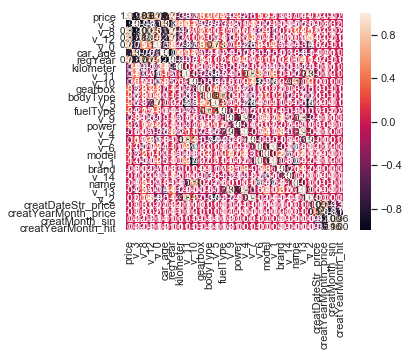

In [11]:
corr_plot(topk=30, dt=dt)

## 车龄销量与价格分布

- car_age对价格影响大，增加对应车龄的平均价格指标特征。

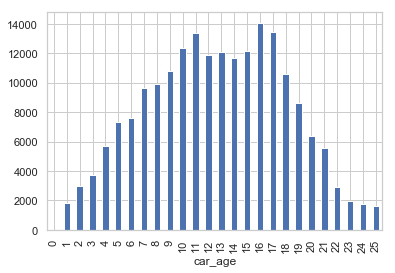

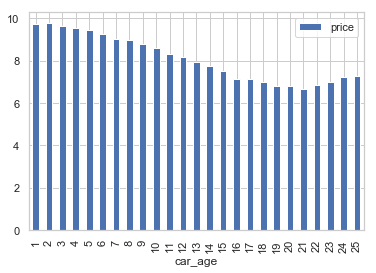

In [12]:
dt[['car_age']].groupby('car_age').size().plot.bar()
dt.loc[dt.isTrain==1, ['car_age','price']].groupby('car_age').mean().plot.bar()

In [13]:
car_age_avg_price = dt.loc[dt.isTrain==1, ['car_age','price']].groupby('car_age').mean().reset_index()
car_age_avg_price.columns = ['car_age', 'car_age_avg_price']
dt = dt.merge(car_age_avg_price, how='left', on=['car_age'])


## 类别hit与price分桶

- 对一些类别型特征进行hit等频分桶、价格等距分桶。
- 涉及的类别特征有：regionCode、name、model、brand，分桶主要是将其转化为品牌大小、地区大小、发达程度等指标特征。

### regionCode

[(0.999, 31.8], (0.999, 31.8], (124.2, 515.0], (0.999, 31.8], (0.999, 31.8], ..., (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0], (124.2, 515.0]]
Length: 155
Categories (5, interval[float64]): [(0.999, 31.8] < (31.8, 62.6] < (62.6, 93.4] < (93.4, 124.2] < (124.2, 515.0]]

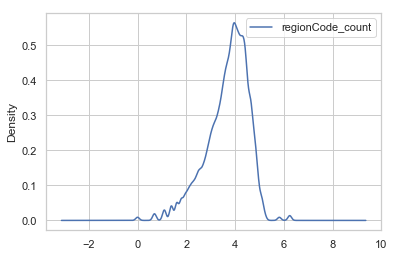

In [14]:
# regionCode
# hit等频分组

regionCode_col = dt.regionCode.value_counts().reset_index(inplace=False)
regionCode_col.columns = ['regionCode', 'regionCode_count']
dt = dt.merge(regionCode_col, how='left', on=['regionCode'])

np.log(dt[['regionCode_count']]).plot.density()

regionCode_count_qcut = pd.qcut(list(set(list(dt['regionCode_count']))), 5) 
regionCode_count_qcut

dt.loc[dt.regionCode_count<=31.8, ['regionCode_count']] = 0
dt.loc[(31.8<dt.regionCode_count) & (dt.regionCode_count<=62.6), ['regionCode_count']] = 1
dt.loc[(62.6<dt.regionCode_count) & (dt.regionCode_count<=93.4), ['regionCode_count']] = 2
dt.loc[(93.4<dt.regionCode_count) & (dt.regionCode_count<=124.2), ['regionCode_count']] = 3
dt.loc[124.2<dt.regionCode_count, ['regionCode_count']] = 4


0         (8.316, 9.663]
1         (8.316, 9.663]
2         (6.968, 8.316]
3         (6.968, 8.316]
4         (8.316, 9.663]
               ...      
199995    (6.968, 8.316]
199996    (6.968, 8.316]
199997    (6.968, 8.316]
199998    (6.968, 8.316]
199999    (6.968, 8.316]
Name: regionCode_price, Length: 200000, dtype: category
Categories (5, interval[float64]): [(4.267, 5.621] < (5.621, 6.968] < (6.968, 8.316] < (8.316, 9.663] < (9.663, 11.01]]

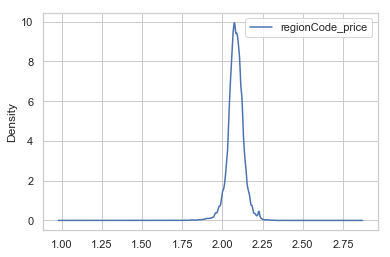

In [15]:
# regionCode
# 价格等距分组


regionCode_price = dt.loc[dt.isTrain==1, ['regionCode','price']].groupby('regionCode').mean().reset_index()
regionCode_price.columns = ['regionCode', 'regionCode_price']
dt = dt.merge(regionCode_price, how='left', on=['regionCode'])

np.log(dt[['regionCode_price']]).plot.density()

regionCode_cut = pd.cut(dt.regionCode_price, 5) 
regionCode_cut

dt['regionCode_price_backet'] = dt['regionCode_price']
dt.loc[dt.regionCode_price_backet<=5.621, ['regionCode_price_backet']] = 0
dt.loc[(5.621<dt.regionCode_price_backet) & (dt.regionCode_price_backet<=6.968), ['regionCode_price_backet']] = 1
dt.loc[(6.968<dt.regionCode_price_backet) & (dt.regionCode_price_backet<=8.316), ['regionCode_price_backet']] = 2
dt.loc[(8.316<dt.regionCode_price_backet) & (dt.regionCode_price_backet<=9.663), ['regionCode_price_backet']] = 3
dt.loc[9.663<dt.regionCode_price_backet, ['regionCode_price_backet']] = 4


dt.drop(['regionCode'], axis=1, inplace=True)

### name

[(0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], (0.999, 19.143], ..., (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0], (169.0, 378.0]]
Length: 128
Categories (7, interval[float64]): [(0.999, 19.143] < (19.143, 37.286] < (37.286, 55.429] < (55.429, 75.571] < (75.571, 103.714] < (103.714, 169.0] < (169.0, 378.0]]

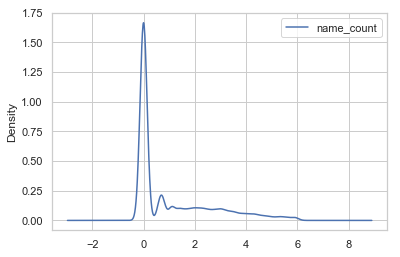

In [16]:
# name
# hit等频分组

name_col = dt.name.value_counts().reset_index(inplace=False)
name_col.columns = ['name', 'name_count']
dt = dt.merge(name_col, how='left', on=['name'])

np.log(dt[['name_count']]).plot.density()

name_count_qcut = pd.qcut(list(set(list(dt['name_count']))), 7) 
name_count_qcut


dt.loc[dt.name_count<=19.143, ['name_count']] = 0
dt.loc[(19.143<dt.name_count) & (dt.name_count<=37.286), ['name_count']] = 1
dt.loc[(37.286<dt.name_count) & (dt.name_count<=55.429), ['name_count']] = 2
dt.loc[(55.429<dt.name_count) & (dt.name_count<=75.571), ['name_count']] = 3 
dt.loc[(75.571<dt.name_count) & (dt.name_count<=103.714), ['name_count']] = 4
dt.loc[(103.714<dt.name_count) & (dt.name_count<=169.0), ['name_count']] = 5 
dt.loc[169.0<dt.name_count, ['name_count']] = 6

0          (6.354, 7.644]
1          (7.644, 8.933]
2         (8.933, 10.223]
3          (7.644, 8.933]
4          (7.644, 8.933]
               ...       
199995     (7.644, 8.933]
199996     (6.354, 7.644]
199997    (8.933, 10.223]
199998                NaN
199999                NaN
Name: name_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(2.476, 3.775] < (3.775, 5.064] < (5.064, 6.354] < (6.354, 7.644] < (7.644, 8.933] < (8.933, 10.223] < (10.223, 11.513]]

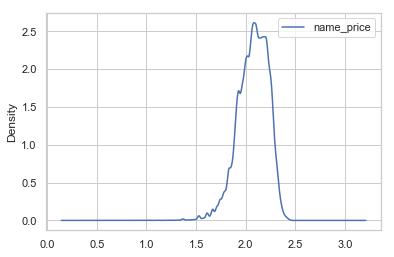

In [17]:
# name
# 价格等距分组


name_price = dt.loc[dt.isTrain==1, ['name','price']].groupby('name').mean().reset_index()
name_price.columns = ['name', 'name_price']
dt = dt.merge(name_price, how='left', on=['name'])

np.log(dt[['name_price']]).plot.density()

name_cut = pd.cut(dt.name_price, 7) 
name_cut

dt['name_price_backet'] = dt['name_price']
dt.loc[dt.name_price_backet<=3.775, ['name_price_backet']] = 0
dt.loc[(3.775<dt.name_price_backet) & (dt.name_price_backet<=5.064), ['name_price_backet']] = 1
dt.loc[(5.064<dt.name_price_backet) & (dt.name_price_backet<=6.354), ['name_price_backet']] = 2
dt.loc[(6.354<dt.name_price_backet) & (dt.name_price_backet<=7.644), ['name_price_backet']] = 3
dt.loc[(7.644<dt.name_price_backet) & (dt.name_price_backet<=8.933), ['name_price_backet']] = 4
dt.loc[(8.933<dt.name_price_backet) & (dt.name_price_backet<=10.223), ['name_price_backet']] = 5
dt.loc[10.223<dt.name_price_backet, ['name_price_backet']] = 6


dt.drop(['name'], axis=1, inplace=True)

### model

[(0.999, 70.714], (0.999, 70.714], (349.857, 559.857], (0.999, 70.714], (0.999, 70.714], ..., (349.857, 559.857], (349.857, 559.857], (349.857, 559.857], (559.857, 1606.143], (1606.143, 15659.0]]
Length: 207
Categories (7, interval[float64]): [(0.999, 70.714] < (70.714, 139.571] < (139.571, 216.571] < (216.571, 349.857] < (349.857, 559.857] < (559.857, 1606.143] < (1606.143, 15659.0]]

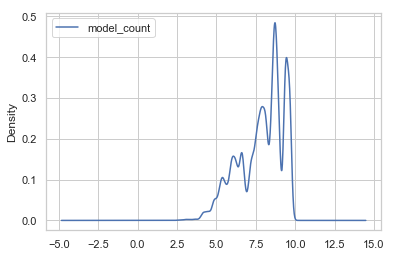

In [18]:
# model
# hit等频分组

model_col = dt.model.value_counts().reset_index(inplace=False)
model_col.columns = ['model', 'model_count']
dt = dt.merge(model_col, how='left', on=['model'])

np.log(dt[['model_count']]).plot.density()

model_count_qcut = pd.qcut(list(set(list(dt['model_count']))), 7) 
model_count_qcut

dt.loc[dt.model_count<=70.714, ['model_count']] = 0
dt.loc[(70.714<dt.model_count) & (dt.model_count<=139.571), ['model_count']] = 1
dt.loc[(139.571<dt.model_count) & (dt.model_count<=216.571), ['model_count']] = 2
dt.loc[(216.571<dt.model_count) & (dt.model_count<=349.857), ['model_count']] = 3 
dt.loc[(349.857<dt.model_count) & (dt.model_count<=559.857), ['model_count']] = 4
dt.loc[(559.857<dt.model_count) & (dt.model_count<=1606.143), ['model_count']] = 5 
dt.loc[1606.143<dt.model_count, ['model_count']] = 6

0         (6.635, 7.312]
1         (7.988, 8.664]
2          (8.664, 9.34]
3          (8.664, 9.34]
4         (6.635, 7.312]
               ...      
199995    (7.988, 8.664]
199996    (7.312, 7.988]
199997    (7.988, 8.664]
199998     (8.664, 9.34]
199999    (7.312, 7.988]
Name: model_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(5.954, 6.635] < (6.635, 7.312] < (7.312, 7.988] < (7.988, 8.664] < (8.664, 9.34] < (9.34, 10.017] < (10.017, 10.693]]

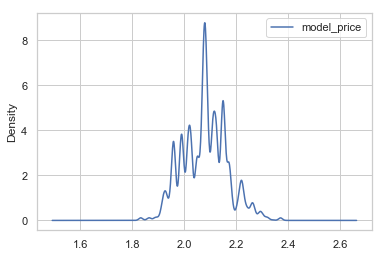

In [19]:
# model
# 价格等距分组


model_price = dt.loc[dt.isTrain==1, ['model','price']].groupby('model').mean().reset_index()
model_price.columns = ['model', 'model_price']
dt = dt.merge(model_price, how='left', on=['model'])

np.log(dt[['model_price']]).plot.density()

model_cut = pd.cut(dt.model_price, 7) 
model_cut


dt['model_price_backet'] = dt['model_price']
dt.loc[dt.model_price_backet<=6.635, ['model_price_backet']] = 0
dt.loc[(6.635<dt.model_price_backet) & (dt.model_price_backet<=7.312), ['model_price_backet']] = 1
dt.loc[(7.312<dt.model_price_backet) & (dt.model_price_backet<=7.988), ['model_price_backet']] = 2
dt.loc[(7.988<dt.model_price_backet) & (dt.model_price_backet<=8.664), ['model_price_backet']] = 3
dt.loc[(8.664<dt.model_price_backet) & (dt.model_price_backet<=9.34), ['model_price_backet']] = 4
dt.loc[(9.34<dt.model_price_backet) & (dt.model_price_backet<=10.017), ['model_price_backet']] = 5
dt.loc[10.017<dt.model_price_backet, ['model_price_backet']] = 6


dt.drop(['model'], axis=1, inplace=True)

### barnd

[(3167.143, 12009.0], (298.857, 747.571], (10.999, 298.857], (2056.143, 3167.143], (747.571, 1320.143], ..., (10.999, 298.857], (747.571, 1320.143], (747.571, 1320.143], (747.571, 1320.143], (10.999, 298.857]]
Length: 39
Categories (7, interval[float64]): [(10.999, 298.857] < (298.857, 747.571] < (747.571, 1320.143] < (1320.143, 2056.143] < (2056.143, 3167.143] < (3167.143, 12009.0] < (12009.0, 41828.0]]

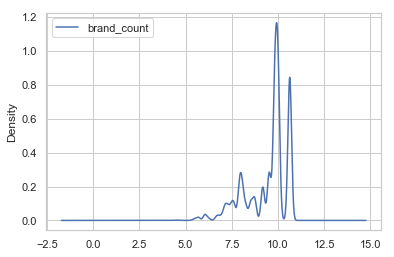

In [20]:
# brand
# hit等频分组

brand_col = dt.brand.value_counts().reset_index(inplace=False)
brand_col.columns = ['brand', 'brand_count']
dt = dt.merge(brand_col, how='left', on=['brand'])

np.log(dt[['brand_count']]).plot.density()

brand_count_qcut = pd.qcut(list(set(list(dt['brand_count']))), 7) 
brand_count_qcut

dt.loc[dt.brand_count<=298.857, ['brand_count']] = 0
dt.loc[(298.857<dt.brand_count) & (dt.brand_count<=747.571), ['brand_count']] = 1
dt.loc[(747.571<dt.brand_count) & (dt.brand_count<=1320.143), ['brand_count']] = 2
dt.loc[(1320.143<dt.brand_count) & (dt.brand_count<=2056.143), ['brand_count']] = 3 
dt.loc[(2056.143<dt.brand_count) & (dt.brand_count<=3167.143), ['brand_count']] = 4
dt.loc[(3167.143<dt.brand_count) & (dt.brand_count<=12009.0), ['brand_count']] = 5 
dt.loc[12009.0<dt.brand_count, ['brand_count']] = 6

0         (7.248, 7.745]
1         (8.242, 8.739]
2         (8.739, 9.236]
3         (8.242, 8.739]
4         (7.248, 7.745]
               ...      
199995    (8.242, 8.739]
199996    (7.745, 8.242]
199997    (8.242, 8.739]
199998    (8.242, 8.739]
199999    (7.248, 7.745]
Name: brand_price, Length: 200000, dtype: category
Categories (7, interval[float64]): [(6.747, 7.248] < (7.248, 7.745] < (7.745, 8.242] < (8.242, 8.739] < (8.739, 9.236] < (9.236, 9.733] < (9.733, 10.231]]

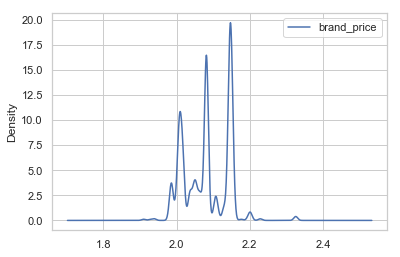

In [21]:
# brand
# 价格等距分组


brand_price = dt.loc[dt.isTrain==1, ['brand','price']].groupby('brand').mean().reset_index()
brand_price.columns = ['brand', 'brand_price']
dt = dt.merge(brand_price, how='left', on=['brand'])

np.log(dt[['brand_price']]).plot.density()

brand_cut = pd.cut(dt.brand_price, 7) 
brand_cut

dt['brand_price_backet'] = dt['brand_price']
dt.loc[dt.brand_price_backet<=7.248, ['brand_price_backet']] = 0
dt.loc[(7.248<dt.brand_price_backet) & (dt.brand_price_backet<=7.745), ['brand_price_backet']] = 1
dt.loc[(7.745<dt.brand_price_backet) & (dt.brand_price_backet<=8.242), ['brand_price_backet']] = 2
dt.loc[(8.242<dt.brand_price_backet) & (dt.brand_price_backet<=8.739), ['brand_price_backet']] = 3
dt.loc[(8.739<dt.brand_price_backet) & (dt.brand_price_backet<=9.236), ['brand_price_backet']] = 4
dt.loc[(9.236<dt.brand_price_backet) & (dt.brand_price_backet<=9.733), ['brand_price_backet']] = 5
dt.loc[9.733<dt.brand_price_backet, ['brand_price_backet']] = 6



dt.drop(['brand'], axis=1, inplace=True)


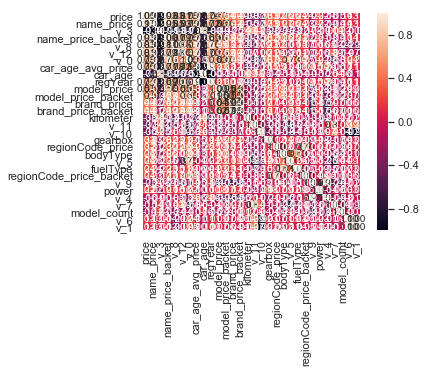

In [22]:
corr_plot(topk=30, dt=dt)

In [23]:
dt.columns

Index(['SaleID', 'bodyType', 'creatDate', 'fuelType', 'gearbox', 'isTrain',
       'kilometer', 'notRepairedDamage', 'offerType', 'power', 'price',
       'seller', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2',
       'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'regYear', 'creatYear',
       'salesDays', 'car_age', 'day_of_week', 'holiday', 'creatWeek_sin',
       'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos',
       'creatYearMonth_hit', 'creatYearMonth_hit_diff1',
       'creatYearMonth_hit_huanbi', 'creatYearMonth_price',
       'creatYearMonth_price_diff1', 'creatYearMonth_price_huanbi',
       'creatDate_is_Weekend', 'creatDateStr_hit', 'creatDateStr_hit_diff1',
       'creatDateStr_hit_huanbi', 'creatDateStr_price',
       'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day',
       'days_to_side', 'car_age_avg_price', 'regionCode_count',
       'regionCode_price', 'regionCode_price_backet', 'name_count',
       'name_price', 'name_price_backet

# 删除列

In [24]:
dt.drop(['creatDate', 'regYear', 'creatYear', 'seller', 'offerType'], axis=1, inplace=True)

# 对数处理

- 消除价格等长尾分布

In [26]:
dt.loc[:,['kilometer']] = dt[['kilometer']].apply(lambda x: np.log(x + 1))
dt.loc[:,['power']] = dt[['power']].apply(lambda x: np.log(x + 1))

In [27]:
dt.columns

Index(['SaleID', 'bodyType', 'fuelType', 'gearbox', 'isTrain', 'kilometer',
       'notRepairedDamage', 'power', 'price', 'v_0', 'v_1', 'v_10', 'v_11',
       'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
       'v_9', 'salesDays', 'car_age', 'day_of_week', 'holiday',
       'creatWeek_sin', 'creatWeek_cos', 'creatMonth_sin', 'creatMonth_cos',
       'creatYearMonth_hit', 'creatYearMonth_hit_diff1',
       'creatYearMonth_hit_huanbi', 'creatYearMonth_price',
       'creatYearMonth_price_diff1', 'creatYearMonth_price_huanbi',
       'creatDate_is_Weekend', 'creatDateStr_hit', 'creatDateStr_hit_diff1',
       'creatDateStr_hit_huanbi', 'creatDateStr_price',
       'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day',
       'days_to_side', 'car_age_avg_price', 'regionCode_count',
       'regionCode_price', 'regionCode_price_backet', 'name_count',
       'name_price', 'name_price_backet', 'model_count', 'model_price',
       'model_price_backet', 'bran

# 数据加载

- 不同模型对建模之前的数据进行编码等处理。

In [28]:
def load_data(dt=dt, m_type = 'xgb-model'):
    """
        加载数据，输出放入模型的特征features列表以及特征列表中是类别型的列表cate_feat
        对cate_feat进行了LabelEncoder，针对LGB增加category转化
    """
    # 参考资料：树模型LabelEncoder——https://www.cnblogs.com/ranjiewen/p/9105954.html:

    noise_feature = [myid, goal, 'isTrain']
    category_feature = ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
    numeric_feature = [i for i in dt.columns if i not in category_feature + noise_feature]
    
    lbl = LabelEncoder()  
    for col in category_feature:
        dt[col] = lbl.fit_transform(dt[col].astype(str))
    if m_type == 'lgb-model':
        for catf in category_feature:
            dt[catf] = dt[catf].astype('category')         
    features = numeric_feature + category_feature
    train = dt[dt.isTrain==1]
    test = dt[dt.isTrain==0]


    return (train, test, features, category_feature)

# 调参

- 步骤繁琐、过程漫长。
- 建议跳过去、先按照大多数的情况去建模，最后再调参。
- 下方的调参过程很粗糙，可进一步细调，没时间就别调整了。

过程：

- 先看看有哪些重要特征，把那些尾部特征删了
- 最佳迭代次数：n_estimators
- 接下来要调试的参数是min_child_weight以及max_depth
- 接着我们就开始调试参数：gamma
- 接着是subsample以及colsample_bytree
- 紧接着就是：reg_alpha以及reg_lambda
- 最后就是learning_rate
- 参考：https://segmentfault.com/a/1190000014040317 、 https://wuhuhu800.github.io/2018/02/28/XGboost_param_share/

## 迭代步长确认

In [29]:
print("=> 载入数据中...")
train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 忽略特征
ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
              # 证明是不重要的特征，XGB上放弃 
              'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
              'creatYearMonth_price', 'creatYearMonth_price_diff1']
features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

print("=> 使用XGB建模...")

cv_params = {
#     'min_child_weight':[0.001, 0.1, 1,],
#     'boosting_type':['dart', 'gbtree'],
#     'n_estimators':[2000, 3000, 5000],
#     'subsample':[0.75]#, 0.8, 0.85, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
#                 'n_estimators': 10, 
                'max_depth': 5, 
                'min_child_weight': 1, 
                'seed': 0,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
                'gamma': 0, 
                'reg_alpha': 0, 
                'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, cv=3)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


=> 建模特征列： ['kilometer', 'power', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'salesDays', 'car_age', 'day_of_week', 'creatWeek_sin', 'creatWeek_cos', 'creatYearMonth_hit_diff1', 'creatYearMonth_hit_huanbi', 'creatYearMonth_price_huanbi', 'creatDateStr_hit', 'creatDateStr_hit_diff1', 'creatDateStr_hit_huanbi', 'creatDateStr_price', 'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day', 'days_to_side', 'car_age_avg_price', 'regionCode_count', 'name_count', 'model_count', 'model_price', 'model_price_backet', 'brand_count', 'brand_price', 'brand_price_backet', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'creatDate_is_Weekend']
=> 建模类别特征列： ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
=> 使用XGBoost建模...
=> 使用XGB建模...
Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=4)]: Done   9 out of   9 | elapsed: 65.2min finished


每轮迭代运行结果:GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=5,
                                    min_child_weight=1, missing=None,
                                    n_estimators=100, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=True,
                                    subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'n_estimators': [2000, 3000, 5000]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)
参数的最佳取值：{'n

## max_depth与min_child_weight参数确认

In [30]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 忽略特征
ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
              # 证明是不重要的特征，XGB上放弃 
              'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
              'creatYearMonth_price', 'creatYearMonth_price_diff1']
features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

print("=> 使用XGB建模...")

cv_params = {
    'min_child_weight':[1, 3, 5, 7],
    'max_depth':[7, 8, 9, 10],
#     'boosting_type':['dart', 'gbtree'],
#     'n_estimators':[2000, 3000, 5000],
#     'subsample':[0.75]#, 0.8, 0.85, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 500, 
#                 'max_depth': 5, 
#                 'min_child_weight': 1, 
                'seed': 0,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
                'gamma': 0, 
                'reg_alpha': 0, 
                'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, cv=4)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['kilometer', 'power', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'salesDays', 'car_age', 'day_of_week', 'creatWeek_sin', 'creatWeek_cos', 'creatYearMonth_hit_diff1', 'creatYearMonth_hit_huanbi', 'creatYearMonth_price_huanbi', 'creatDateStr_hit', 'creatDateStr_hit_diff1', 'creatDateStr_hit_huanbi', 'creatDateStr_price', 'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day', 'days_to_side', 'car_age_avg_price', 'regionCode_count', 'name_count', 'model_count', 'model_price', 'model_price_backet', 'brand_count', 'brand_price', 'brand_price_backet', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'creatDate_is_Weekend']
=> 建模类别特征列： ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
=> 使用XGBoost建模...
=> 使用XGB建模...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 4 folds for each of 16 candidates, totalling 64 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed: 74.3min
[Parallel(n_jobs=4)]: Done  64 out of  64 | elapsed: 113.6min finished


每轮迭代运行结果:GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=3,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=True,
                                    subsample=0.8),
             iid='warn', n_jobs=4,
             param_grid={'max_depth': [7, 8, 9, 10],
                         'min_child_weight': [1, 3, 5, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scorin

## gamma参数确认

In [31]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 忽略特征
ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
              # 证明是不重要的特征，XGB上放弃 
              'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
              'creatYearMonth_price', 'creatYearMonth_price_diff1']
features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

print("=> 使用XGB建模...")

cv_params = {
#     'min_child_weight':[1, 3, 5, 7],
#     'max_depth':[7, 8, 9, 10],
    'gamma':[i/10.0 for i in range(0,4)],
#     'boosting_type':['dart', 'gbtree'],
#     'n_estimators':[2000, 3000, 5000],
#     'subsample':[0.75]#, 0.8, 0.85, 0.9]
    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 500, 
                'max_depth': 10, 
                'min_child_weight': 1, 
                'seed': 0,
                'subsample': 0.8, 
                'colsample_bytree': 0.8, 
#                 'gamma': 0, 
                'reg_alpha': 0, 
                'reg_lambda': 1}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, cv=4)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['kilometer', 'power', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'salesDays', 'car_age', 'day_of_week', 'creatWeek_sin', 'creatWeek_cos', 'creatYearMonth_hit_diff1', 'creatYearMonth_hit_huanbi', 'creatYearMonth_price_huanbi', 'creatDateStr_hit', 'creatDateStr_hit_diff1', 'creatDateStr_hit_huanbi', 'creatDateStr_price', 'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day', 'days_to_side', 'car_age_avg_price', 'regionCode_count', 'name_count', 'model_count', 'model_price', 'model_price_backet', 'brand_count', 'brand_price', 'brand_price_backet', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'creatDate_is_Weekend']
=> 建模类别特征列： ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
=> 使用XGBoost建模...
=> 使用XGB建模...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed: 33.9min finished


每轮迭代运行结果:GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.8,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=10,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=True,
                                    subsample=0.8),
             iid='warn', n_jobs=4, param_grid={'gamma': [0.0, 0.1, 0.2, 0.3]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbose=1)
参数的最佳取值：{'gamma': 0.0}
最佳模型得

## colsample_bytree与subsample参数确认

In [32]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 忽略特征
ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
              # 证明是不重要的特征，XGB上放弃 
              'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
              'creatYearMonth_price', 'creatYearMonth_price_diff1']
features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

print("=> 使用XGB建模...")

cv_params = {
#     'min_child_weight':[1, 3, 5, 7],
#     'max_depth':[7, 8, 9, 10],
#     'gamma':[i/10.0 for i in range(0,4)],
    'subsample':[0.8, 0.9],
    'colsample_bytree':[0.7, 0.75, 0.8, 0.9],
#     'boosting_type':['dart', 'gbtree'],
#     'n_estimators':[2000, 3000, 5000],

    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 500, 
                'max_depth': 10, 
                'min_child_weight': 1, 
                'gamma': 0, 
#                 'subsample': 0.8, 
#                 'colsample_bytree': 0.8, 
                'reg_alpha': 0, 
                'reg_lambda': 1,
                'seed': 0}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, cv=4)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...
=> 建模特征列： ['kilometer', 'power', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'salesDays', 'car_age', 'day_of_week', 'creatWeek_sin', 'creatWeek_cos', 'creatYearMonth_hit_diff1', 'creatYearMonth_hit_huanbi', 'creatYearMonth_price_huanbi', 'creatDateStr_hit', 'creatDateStr_hit_diff1', 'creatDateStr_hit_huanbi', 'creatDateStr_price', 'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day', 'days_to_side', 'car_age_avg_price', 'regionCode_count', 'name_count', 'model_count', 'model_price', 'model_price_backet', 'brand_count', 'brand_price', 'brand_price_backet', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'creatDate_is_Weekend']
=> 建模类别特征列： ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
=> 使用XGBoost建模...
=> 使用XGB建模...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


Fitting 4 folds for each of 8 candidates, totalling 32 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  32 out of  32 | elapsed: 66.8min finished


每轮迭代运行结果:GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=1,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=10,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=True,
                                    subsample=1),
             iid='warn', n_jobs=4,
             param_grid={'colsample_bytree': [0.7, 0.75, 0.8, 0.9],
                         'subsample': [0.8, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             sco

## reg_alpha与reg_lambda参数确认

In [33]:
print("=> 载入数据中...")
# train, test, features, category_feature = load_data(dt=dt, m_type='xgb-model')
mean_val = test['car_age_avg_price'].mean()
test['car_age_avg_price'].fillna(mean_val, inplace=True)
# 忽略特征
ignore_col = ['name_price', 'name_price_backet', 'regionCode_price', 'regionCode_price_backet', # 在测试集上缺失太多的数据，XGB上放弃
              # 证明是不重要的特征，XGB上放弃 
              'creatMonth_sin', 'creatMonth_cos', 'holiday', 'creatYearMonth_hit', 
              'creatYearMonth_price', 'creatYearMonth_price_diff1']
features =  [i for i in features if i not in ignore_col]

print("=> 建模特征列：", features)
print("=> 建模类别特征列：", category_feature)
print("=> 使用XGBoost建模...")

print("=> 使用XGB建模...")

cv_params = {
#     'min_child_weight':[1, 3, 5, 7],
#     'max_depth':[7, 8, 9, 10],
#     'gamma':[i/10.0 for i in range(0,4)],
#     'subsample':[0.8, 0.9],
#     'colsample_bytree':[0.7, 0.75, 0.8, 0.9],
    'reg_alpha': [0.01, 0.1],
    'reg_lambda': [0.3, 0.8],
#     'boosting_type':['dart', 'gbtree'],
#     'n_estimators':[2000, 3000, 5000],

    
}

other_params = {'learning_rate': 0.1, 
                'n_estimators': 500, 
                'max_depth': 10, 
                'min_child_weight': 1, 
                'gamma': 0, 
                'subsample': 0.9, 
                'colsample_bytree': 0.7, 
#                 'reg_alpha': 0, 
#                 'reg_lambda': 1,
                'seed': 0}

model = xgb.XGBRegressor(**other_params)

gsearch1 = GridSearchCV(estimator = model, param_grid = cv_params, 
                        scoring='neg_mean_absolute_error', n_jobs=4, verbose=1, cv=4)
evalute_result = gsearch1.fit(train[features], train[goal])
print('每轮迭代运行结果:{0}'.format(evalute_result))
print('参数的最佳取值：{0}'.format(gsearch1.best_params_))
print('最佳模型得分:{0}'.format(gsearch1.best_score_))

=> 载入数据中...


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


=> 建模特征列： ['kilometer', 'power', 'v_0', 'v_1', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'salesDays', 'car_age', 'day_of_week', 'creatWeek_sin', 'creatWeek_cos', 'creatYearMonth_hit_diff1', 'creatYearMonth_hit_huanbi', 'creatYearMonth_price_huanbi', 'creatDateStr_hit', 'creatDateStr_hit_diff1', 'creatDateStr_hit_huanbi', 'creatDateStr_price', 'creatDateStr_price_diff1', 'creatDateStr_price_huanbi', 'day', 'days_to_side', 'car_age_avg_price', 'regionCode_count', 'name_count', 'model_count', 'model_price', 'model_price_backet', 'brand_count', 'brand_price', 'brand_price_backet', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'creatDate_is_Weekend']
=> 建模类别特征列： ['bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'holiday', 'creatDate_is_Weekend']
=> 使用XGBoost建模...
=> 使用XGB建模...
Fitting 4 folds for each of 4 candidates, totalling 16 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  16 out of  16 | elapsed: 29.0min finished


每轮迭代运行结果:GridSearchCV(cv=4, error_score='raise-deprecating',
             estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                    colsample_bylevel=1, colsample_bytree=0.7,
                                    gamma=0, learning_rate=0.1,
                                    max_delta_step=0, max_depth=10,
                                    min_child_weight=1, missing=None,
                                    n_estimators=500, n_jobs=1, nthread=None,
                                    objective='reg:linear', random_state=0,
                                    reg_alpha=0, reg_lambda=1,
                                    scale_pos_weight=1, seed=0, silent=True,
                                    subsample=0.9),
             iid='warn', n_jobs=4,
             param_grid={'reg_alpha': [0.01, 0.1], 'reg_lambda': [0.3, 0.8]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_absolute_error', verbo

# 训练与分析

XGB交叉验证...
[0]	train-mae:7.15864	test-mae:7.15862
[500]	train-mae:0.0542173	test-mae:0.117735
[1000]	train-mae:0.0334277	test-mae:0.115899
[1500]	train-mae:0.0218387	test-mae:0.115033
[2000]	train-mae:0.014797	test-mae:0.114463
[2500]	train-mae:0.010389	test-mae:0.114089
[3000]	train-mae:0.007679	test-mae:0.113846
[3500]	train-mae:0.00592933	test-mae:0.11369
[4000]	train-mae:0.00478033	test-mae:0.113584
[4500]	train-mae:0.00400533	test-mae:0.113515
[5000]	train-mae:0.00346733	test-mae:0.113467
[5500]	train-mae:0.00307833	test-mae:0.113433
[5999]	train-mae:0.002798	test-mae:0.113407


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.7, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=6000, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=0.1, reg_lambda=0.3, scale_pos_weight=1,
             seed=202001, silent=True, subsample=0.9)

XGB训练...


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=0.7, gamma=0, learning_rate=0.05,
             max_delta_step=0, max_depth=10, min_child_weight=1, missing=None,
             n_estimators=6000, n_jobs=1, nthread=4, objective='reg:linear',
             random_state=0, reg_alpha=0.1, reg_lambda=0.3, scale_pos_weight=1,
             seed=202001, silent=True, subsample=0.9)

训练集MAE： 25.01776837765375
XGB迭代次数... 6000
XGB测试集预测...


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


XGB的特征重要性...


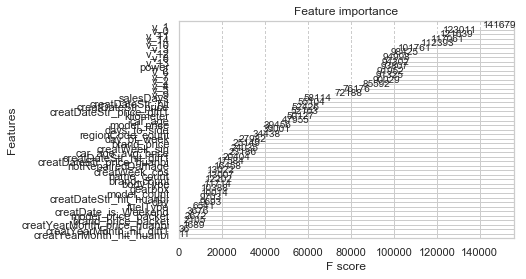

In [36]:
xgbRegr = XGBRegressor(
    learning_rate =0.05,
    n_estimators=6000,
    max_depth = 10,
    min_child_weight=1,
    reg_alpha= 0.1,
    reg_lambda= 0.3,
    gamma=0,
    subsample=0.9,
    colsample_bytree=0.7,
    objective= 'reg:linear',
    nthread=4,
    seed=202001)
print('XGB交叉验证...')
xgb_param = xgbRegr.get_xgb_params()
dtrain = xgb.DMatrix(train[features], train[goal])
cvresult = xgb.cv(xgb_param, 
                  dtrain,
                  num_boost_round=xgbRegr.get_params()['n_estimators'], 
                  nfold=3, 
                  metrics='mae',
                  early_stopping_rounds=200, 
                  verbose_eval=500, 
                  show_stdv=False, 
                  seed=202002, 
                  callbacks=None, 
                  shuffle=True)
xgbRegr.set_params(n_estimators=cvresult.shape[0])
print('XGB训练...')
xgbRegr.fit(train[features], train[goal], eval_metric='mae')
print('训练集MAE：', np.mean(abs(np.exp(xgbRegr.predict(train[features])) - 1 - np.exp(train[goal]) - 1)))
print('XGB迭代次数...', xgbRegr.n_estimators)
print('XGB测试集预测...')
price_pre1 = np.exp(xgbRegr.predict(test[features])) - 1

#Plot feature importance 
print('XGB的特征重要性...')
plot_importance(xgbRegr)
plt.show()

# 保存结果

In [ ]:
submission = pd.DataFrame({myid: test[myid], goal: np.int64(price_pre1)})
submission.to_csv("./result/sample_submit_xgboost.csv", index=False)